# SNN_0

This code is designed to demo the use of a Spiking Neural Network to propogate spikes between neurons. At this stage there is no learning involved, it's purely about propogating spikes between LIF neurons.

More biologically plausible neurons and learning will be introduced later.

### Set up the environment

In [1]:
import numpy as np
from mnist import MNIST   
import cv2
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
duration = 50        # Length of each time period (ms)

### Utility functions

In [3]:
def plot_neuron_behaviour(time, data, neuron_type, neuron_id, y_title):
    #print ('Drawing graph with time.shape={}, data.shape={}'.format(time.shape, data.shape))
    plt.plot(time,data)
    plt.title('{} @ {}'.format(neuron_type, neuron_id))
    plt.ylabel(y_title)
    plt.xlabel('Time (msec)')
    plt.ylim([0,2])
    plt.show()

In [4]:
def plot_membrane_potential(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Membrane potential (V)')

def plot_spikes(time, Vm, neuron_type, neuron_id = 0):
    plot_neuron_behaviour(time, Vm, neuron_type, neuron_id, y_title = 'Spike (V)')

### Create a basic neuron class

Use LIF neuron for now, this can be made more complex over time.

Based on http://neurdon.wpengine.com/2011/01/19/neural-modeling-with-python-part-1/

In [13]:
class Neuron():
    def __init__(self, debug=True):
        # Simulation config (may not all be needed!!)
        self.dt       = 0.125       # simulation time step
        self.t_rest   = 0           # initial refractory time
        
        #LIF Properties 
        self.Vm       = np.array([0])    # Neuron potential (mV)
        self.time     = np.array([0])    # Time duration for the neuron (needed?)
        self.spikes   = np.array([0])    # Output (spikes) for the neuron

        #self.output   = 0               # Neuron output
        self.t        = 0                # Neuron time step
        self.Rm       = 1                # Resistance (kOhm)
        self.Cm       = 10               # Capacitance (uF) 
        self.tau_m    = self.Rm * self.Cm # Time constant
        self.tau_ref  = 4                # refractory period (ms)
        self.Vth      = 0.75             # = 1  #spike threshold
        self.V_spike  = 1                # spike delta (V)
        self.type     = 'Leaky Integrate and Fire'
        self.debug    = debug
        if self.debug:
            print ('Neuron(): Created {} neuron starting at time {}'.format(self.type, self.t))
    
    def spike_generator(self, neuron_input):
        # Create local arrays for this run
        duration = len(neuron_input)
        Vm = np.zeros(duration)  #len(time)) # potential (V) trace over time
        time = np.arange(self.t, self.t+duration)       
        spikes = np.zeros(duration)  #len(time))
        
        if self.debug:
            print ('spike_generator(): Running time period self.t={}, self.t+duration={}'
                   .format(self.t, self.t+duration))
        
        # Seed the new array with previous value of last run
        Vm[-1] = self.Vm[-1]
        
        if self.debug:
            print ('Neuron.spike_generator.initial_state(input={}, duration={}, initial Vm={}, t={})'
               .format(neuron_input, duration, Vm[-1], self.t))
            
        for i in range(duration):
            if self.debug:
                print ('Index {}'.format(i))
                
            if self.t > self.t_rest:
                Vm[i]=Vm[i-1] + (-Vm[i-1] + neuron_input[i-1]*self.Rm) / self.tau_m * self.dt

                if self.debug:
                    print('spike_generator(): i={}, self.t={}, Vm[i]={}, neuron_input={}, self.Rm={}, self.tau_m * self.dt = {}'
                          .format(i,self.t, Vm[i], neuron_input[i], self.Rm, self.tau_m * self.dt))
                
                if Vm[i] >= self.Vth:
                    spikes[i] += self.V_spike
                    self.t_rest = self.t + self.tau_ref
                    if self.debug:
                        print ('*** Neuron.spike_generator.spike=(self.t_rest={}, self.t={}, self.tau_ref={})'
                           .format(self.t_rest, self.t, self.tau_ref))

            self.t += self.dt
        
        # Save state
        self.Vm = np.append(self.Vm, Vm)
        self.spikes = np.append(self.spikes, spikes)
        self.time = np.append(self.time, time)
        
        if self.debug:
            print ('Neuron.spike_generator.exit_state(Vm={} at iteration i={}, time={})'
                   .format(self.Vm, i, self.t))
        
        #return time, Vm, output

* Assume a consistent/single input value for now

In [14]:
T         = 20    # total time to sumulate (msec)
dt        = 0.0125 # Simulation timestep
time      = int(T / dt)
inpt      = 0.9   # Neuron input voltage
neuron_input=np.full((time),inpt)

### Create an array of neurons

For now, create 2 layers with specified number of neurons in a specified number of layers

In [15]:
def create_neurons(num_layers, num_neurons, debug=True):
    neurons = []
    for layer in range(num_layers):
        if debug:
            print ('create_neurons(): Creating layer {}'.format(layer))
        neuron_layer = []
        for count in range(num_neurons):
            neuron_layer.append(Neuron(debug=debug))
        neurons.append(neuron_layer)
    return neurons

* Create initial neuron model 

In [62]:
num_layers = 2
num_neurons = 100
neurons = create_neurons(num_layers, num_neurons, debug=False)    # 2 rows of 10 neurons each

* Run stimuli for each neurons in layer 0. Assume the same stimuli for now

In [63]:
print (len(neuron_input))
layer = 0
for neuron in range(num_neurons):
    neurons[layer][neuron].spike_generator(neuron_input)

1600


* Graph out the membrane potential and output of a neuron in the 1st layer

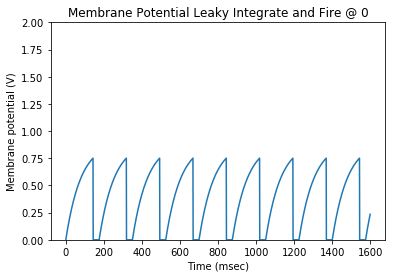

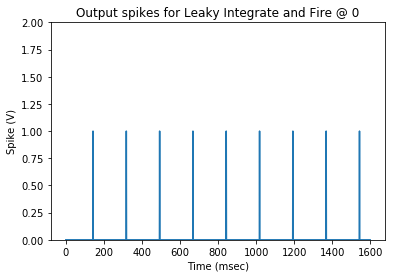

In [64]:
plot_membrane_potential(neurons[0][0].time, neurons[0][0].Vm, 'Membrane Potential {}'.format(neurons[0][0].type), neuron_id = "0")
plot_spikes(neurons[0][0].time, neurons[0][0].spikes, 'Output spikes for {}'.format(neurons[0][0].type), neuron_id = "0")

* Sum the spikes from the neurons in the 1st layer (layer=0)

In [65]:
print (type(neurons[0][0].spikes))

<class 'numpy.ndarray'>


In [66]:
layer = 0 
layer_spikes = np.zeros_like(neurons[layer][0].spikes)
for i in range(num_neurons):
    layer_spikes += neurons[layer][i].spikes    

In [67]:
print (layer_spikes[100:200])

[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.  100.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.]


* Graph summed spike train from first layer


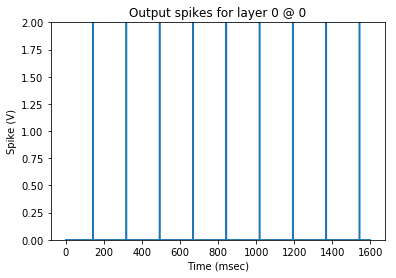

In [68]:
plot_spikes(neurons[0][0].time, layer_spikes, 'Output spikes for layer {}'.format(layer))

In [69]:
neurons[1][0]=Neuron()
neurons[1][0].spike_generator(layer_spikes)   #[time_step], duration=0.25)

Neuron(): Created Leaky Integrate and Fire neuron starting at time 0
spike_generator(): Running time period self.t=0, self.t+duration=1601
Neuron.spike_generator.initial_state(input=[ 0.  0.  0. ...,  0.  0.  0.], duration=1601, initial Vm=0.0, t=0)
Index 0
Index 1
spike_generator(): i=1, self.t=0.125, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 2
spike_generator(): i=2, self.t=0.25, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 3
spike_generator(): i=3, self.t=0.375, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 4
spike_generator(): i=4, self.t=0.5, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 5
spike_generator(): i=5, self.t=0.625, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 6
spike_generator(): i=6, self.t=0.75, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 7
spike_generator(): i=7, self.t=0.875, Vm[i]=0.0, neuro

Index 871
Index 872
Index 873
Index 874
Index 875
Index 876
Index 877
Index 878
spike_generator(): i=878, self.t=109.75, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 879
spike_generator(): i=879, self.t=109.875, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 880
spike_generator(): i=880, self.t=110.0, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 881
spike_generator(): i=881, self.t=110.125, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 882
spike_generator(): i=882, self.t=110.25, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 883
spike_generator(): i=883, self.t=110.375, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 884
spike_generator(): i=884, self.t=110.5, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self.tau_m * self.dt = 1.25
Index 885
spike_generator(): i=885, self.t=110.625, Vm[i]=0.0, neuron_input=0.0, self.Rm=1, self

In [70]:
start_time = 0
end_time = len(neurons[1][0].time)
print(start_time,end_time)

0 1602


In [71]:
print (neurons[1][0].time.shape)
print (neurons[1][0].time)

(1602,)
[   0    0    1 ..., 1598 1599 1600]


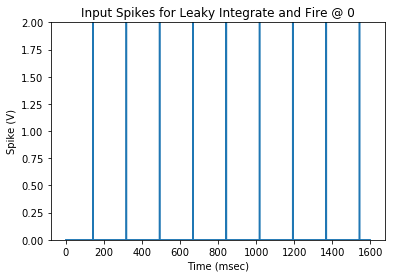

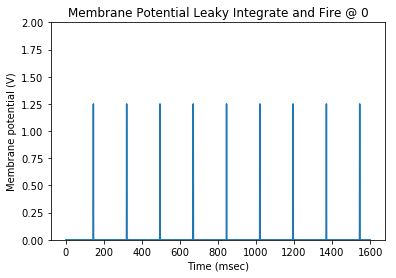

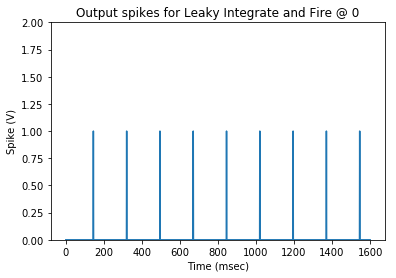

In [72]:
plot_spikes(neurons[0][0].time[start_time:end_time], layer_spikes[start_time:end_time], 
            'Input Spikes for {}'.format(neurons[1][0].type), neuron_id = "0")
plot_membrane_potential(neurons[1][0].time[start_time:end_time], neurons[1][0].Vm[start_time:end_time], 
            'Membrane Potential {}'.format(neurons[1][0].type), neuron_id = "0")
plot_spikes(neurons[1][0].time[start_time:end_time], neurons[1][0].spikes[start_time:end_time], 
            'Output spikes for {}'.format(neurons[1][0].type), neuron_id = "0")